In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pic

from sklearn.model_selection import train_test_split

from templates import classifications_per_trace, reconstruct_key, guessing_entropy

In [2]:
import deep_learning

2024-05-23 08:39:59.056667: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 08:40:03.156601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 08:40:09.956761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, output_total, keyshares_total, perms_total = pic.load(r)

In [4]:
X_total, y_total = deep_learning.prepare_data_dl(seeds_total, traces_total, key, keyshares_total, perms_total)

X_profiling, X_extraction = train_test_split(X_total, test_size=100_000, random_state=0)
y_profiling = {}
y_extraction = {}
for label in y_total.keys():
    train, test = train_test_split(y_total[label], test_size=100_000, random_state=0)
    y_profiling[label] = train
    y_extraction[label] = test

In [5]:
y_predicted = deep_learning.extract_key(X_extraction, "./resnet_models/resnet_300000_35_epochs.keras")
y_predicted = [np.log(pred) for pred in y_predicted]

2024-05-23 08:45:22.284664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:41:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 08:45:22.284791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 08:45:22.574631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:41:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 08:45:22.574684: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 08:45:22.574711: I external/local_xla/xla/stream_executor

  19/3125 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step 

I0000 00:00:1716446760.846548    3520 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step


In [6]:
with open("y_extraction_epoch_35.pic", "wb") as w:
    pic.dump(y_predicted, w)

In [3]:
with open("y_extraction_epoch_35.pic", "rb") as r:
    y_predicted = pic.load(r)

In [4]:
len(y_predicted)

9

In [5]:
y_predicted[2:][0].shape

(100000, 256)

In [23]:
_, seeds_extraction = train_test_split(seeds_total, test_size=100_000, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
masks_probas = np.stack(y_predicted[2:], axis=1)[:, np.newaxis, ...]

per_trace = classifications_per_trace(seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, masks_rws_keep_only=np.empty((98, 0)), parallel=True)
recovered_key = reconstruct_key(per_trace)

In [24]:
from utils import KEY_WIDTH_B4
np.count_nonzero(recovered_key == key) / KEY_WIDTH_B4

0.109375

In [25]:
np.count_nonzero(np.argmax(round_perm_probas, axis=1) == train_test_split(perms_total, test_size=100000, random_state=0)[1][:, 1]) / round_perm_probas.shape[0]

0.48529

In [26]:
np.count_nonzero(np.argmax(copy_perm_probas, axis=2)[:, 0] == train_test_split(perms_total, test_size=100_000, random_state=0)[1][:, 2]) / round_perm_probas.shape[0]

0.86883

In [27]:
from templates import get_masks_labels
masks_labels = get_masks_labels(seeds_extraction, key, train_test_split(keyshares_total, test_size=100_000, random_state=0)[1], train_test_split(perms_total, test_size=100_000, random_state=0)[1][:, 1], train_test_split(perms_total, test_size=100_000, random_state=0)[1][:, 2:3:1])
for i in range(7):
    print(np.count_nonzero(np.argmax(masks_probas[:, 0, i], axis=1) == 16 * masks_labels[0, i, 0] + masks_labels[0, i, 1]) / round_perm_probas.shape[0])

0.00769
0.00809
0.0074
0.00746
0.00654
0.00735
0.00764


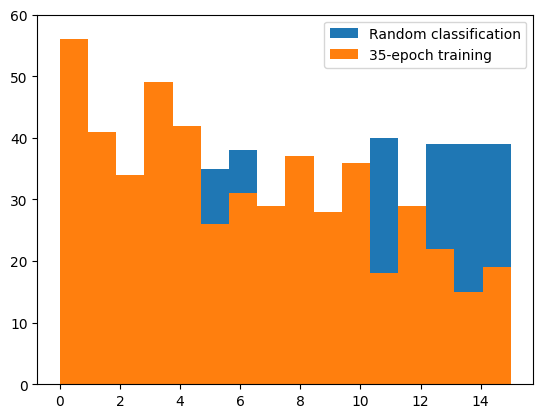

: 

In [29]:
import matplotlib.pyplot as plt
#import seaborn as sns
classifications_per_key_nibble = np.sum(per_trace, axis=0)
rand = np.random.uniform(low=np.min(classifications_per_key_nibble), high=np.max(classifications_per_key_nibble), size=classifications_per_key_nibble.shape)
plt.hist(np.argmax(np.argsort(rand, axis=1)[:, ::-1] == key[:, np.newaxis], axis=1), bins=16, label="Random classification")
plt.hist(np.argmax(np.argsort(classifications_per_key_nibble, axis=1)[:, ::-1] == key[:, np.newaxis], axis=1), bins=16, label="35-epoch training")
plt.legend()
plt.ylim([0, 60])
plt.show()